In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#matplotlib inline 
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)



2.0.0-rc1
matplotlib 2.1.0
numpy 1.18.0
pandas 0.20.3
sklearn 0.21.3
tensorflow 2.0.0-rc1
tensorflow_core.keras 2.2.4-tf


In [2]:
#  泰坦尼克号生存预测
#https://storage.googleapis.com/tf-datasets/titanic/eval.csv
#https://storage.googleapis.com/tf-datasets/titanic/train.csv
train_file="./data/titanic/train.csv"
eval_file="./data/titanic/eval.csv"
 
train_df=pd.read_csv(train_file)
eval_df=pd.read_csv(eval_file)
 
print(train_df.head())
print(eval_df.head())


   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         

In [3]:
y_train=train_df.pop('survived')
y_eval=eval_df.pop('survived')
print(train_df.head())
print(eval_df.head())
print(y_eval.head())
print(y_train.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

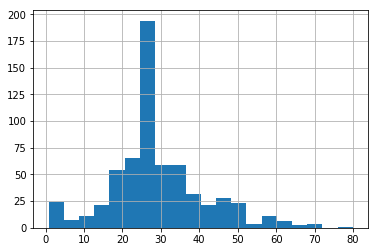

In [10]:
train_df.age.hist(bins=20)
plt.show()

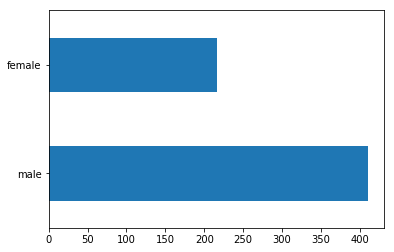

In [11]:
train_df.sex.value_counts().plot(kind='barh')
plt.show()

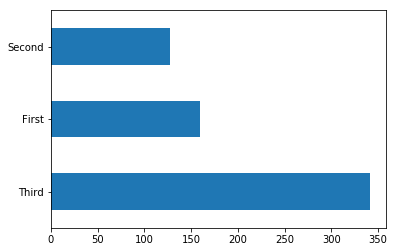

In [12]:
train_df['class'].value_counts().plot(kind='barh')
plt.show()

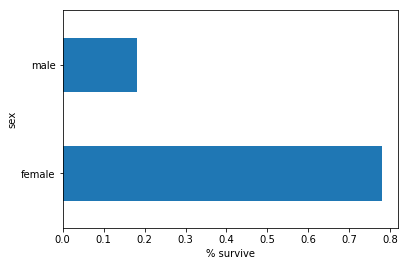

In [13]:
pd.concat([train_df, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
plt.show()

In [ ]:
def calc_age_section(n, lim):
    return'[%.f,%.f)' % (lim*(n//lim), lim*(n//lim)+lim)  # map function

addone = pd.Series([calc_age_section(s, 10) for s in train_df.age])
train_df['ages'] = addone
pd.concat([train_df, y_train], axis=1).groupby('ages').survived.mean().plot(kind='barh').set_xlabel('% survive');
plt.show()

In [5]:
#Tf.feature_column使用
categorical_columns=['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']#离散特征
numeric_columns=['age','fare']  #连续特征
feature_columns=[]
for categorical_column in categorical_columns:  #离散特征处理
    vocab=train_df[categorical_column].unique()  #  读取离散特征所有的值
    print(categorical_column,vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
    categorical_column,vocab)))#离散特征编码化

for categorical_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            categorical_column,dtype=tf.float64))


sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [6]:
feature_columns.append(tf.feature_column.indicator_column(
    tf.feature_column.crossed_column(['age','sex'],hash_bucket_size=100)))#表示压缩矩阵

#构建dataset
def make_dataset(data_df,label_df,epoch=10,shuffle=True,batch_size=32):
    dataset=tf.data.Dataset.from_tensor_slices((dict(data_df),label_df))
    if shuffle:
        dataset=dataset.shuffle(10000)
    dataset=dataset.repeat(epoch).batch(batch_size)
    return dataset


In [9]:
output_dir="./model/baseline"
# baseline_estimator = tf.estimator.BaselineClassifier(model_dir=output_dir,n_classes=2)
baseline_estimator = tf.compat.v1.estimator.BaselineClassifier(model_dir=output_dir,n_classes=2)
baseline_estimator.train(input_fn= lambda : make_dataset(train_df,y_train,epoch=100))


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model/baseline', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb45c264278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create 

In [19]:
model = keras.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(2,activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
             optimizer = keras.optimizers.SGD(lr=0.01),
             metrics=['accuracy'])

# model.summary()

In [22]:
# 1.model.fit
# 2.model->estimator->train

train_dataset = make_dataset(train_df,y_train,epoch=100)
eval_dataset = make_dataset(eval_df,y_eval,epoch=1,shuffle=False)
history = model.fit(train_dataset,
                    validation_data=eval_dataset,
                    steps_per_epoch=20,
                    validation_steps = 8,
                    epochs=100)




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Train for 20 steps, validate for 8 steps
Epoch 1/100
20/20 [==============================] - 1s 45ms/step - loss: 1.7118 - accuracy: 0.

20/20 [==============================] - 0s 3ms/step - loss: 0.5764 - accuracy: 0.7031 - val_loss: 0.5735 - val_accuracy: 0.6758
Epoch 45/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5405 - accuracy: 0.7188 - val_loss: 0.6015 - val_accuracy: 0.6641
Epoch 46/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5528 - accuracy: 0.7312 - val_loss: 0.5379 - val_accuracy: 0.6758
Epoch 47/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5521 - accuracy: 0.7266 - val_loss: 0.5684 - val_accuracy: 0.7188
Epoch 48/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5634 - accuracy: 0.7094 - val_loss: 0.5432 - val_accuracy: 0.6953
Epoch 49/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5507 - accuracy: 0.7312 - val_loss: 0.5375 - val_accuracy: 0.7070
Epoch 50/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5273 - accuracy: 0.7219 - val_loss: 0.5268 - val_accuracy: 0.7266
Epoch 51/100
20/20 

ValueError: Empty training data.

In [25]:
estimator = keras.estimator.model_to_estimator(model)
# input_fn   1.function
#2.return a.(features,labels)  b.dataset->(feature,label)
estimator.train(input_fn = lambda : make_dataset(train_df,y_train,epoch=100)) #2.0bug   名字没有被保存下来

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpk1jfm2t2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb44c7cd278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True

KeyError: "The dictionary passed into features does not have the expected inputs keys defined in the keras model.\n\tExpected keys: {'input_3', 'input_2', 'input_6', 'input_9', 'input_5', 'input_1', 'input_7', 'input_8', 'input_4'}\n\tfeatures keys: {'n_siblings_spouses', 'embark_town', 'sex', 'fare', 'deck', 'alone', 'parch', 'age', 'class'}\n\tDifference: {'n_siblings_spouses', 'embark_town', 'input_3', 'input_2', 'sex', 'input_6', 'fare', 'deck', 'alone', 'age', 'input_9', 'input_5', 'input_1', 'parch', 'input_7', 'class', 'input_8', 'input_4'}"

In [28]:
baseline_estimator = tf.compat.v1.estimator.BaselineClassifier(model_dir = "model/baseline0",n_classes=2)
baseline_estimator.train(input_fn=lambda : make_dataset(train_df,y_train,epoch=100))

baseline_estimator.evaluate(input_fn=lambda : make_dataset(eval_df,y_eval,epoch=1,shuffle=False,batch_size=20))



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model/baseline0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb4006257f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create C

{'accuracy': 0.625,
 'accuracy_baseline': 0.625,
 'auc': 0.5,
 'auc_precision_recall': 0.6875,
 'average_loss': 0.66189665,
 'global_step': 1960,
 'label/mean': 0.375,
 'loss': 12.481479,
 'precision': 0.0,
 'prediction/mean': 0.38755488,
 'recall': 0.0}

In [30]:
linear_estimator = tf.compat.v1.estimator.LinearClassifier(model_dir = "model/linear",n_classes=2,
                                                           feature_columns = feature_columns)
linear_estimator.train(input_fn=lambda : make_dataset(train_df,y_train,epoch=100))

linear_estimator.evaluate(input_fn=lambda : make_dataset(eval_df,y_eval,epoch=1,shuffle=False,batch_size=20))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model/linear', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3f0132358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely igno

{'accuracy': 0.8030303,
 'accuracy_baseline': 0.625,
 'auc': 0.8534129,
 'auc_precision_recall': 0.7804653,
 'average_loss': 0.4860904,
 'global_step': 1960,
 'label/mean': 0.375,
 'loss': 9.166276,
 'precision': 0.7155963,
 'prediction/mean': 0.4257359,
 'recall': 0.7878788}

In [32]:
dnn_estimator = tf.compat.v1.estimator.DNNClassifier(model_dir = "model/dnn",n_classes=2,
                                                           feature_columns = feature_columns,hidden_units = [128,128],
                                                           activation_fn = tf.nn.relu, optimizer = 'Adam')
dnn_estimator.train(input_fn=lambda : make_dataset(train_df,y_train,epoch=100))

dnn_estimator.evaluate(input_fn=lambda : make_dataset(eval_df,y_eval,epoch=1,shuffle=False,batch_size=20))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model/dnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3c447abe0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore 

{'accuracy': 0.78409094,
 'accuracy_baseline': 0.625,
 'auc': 0.81659013,
 'auc_precision_recall': 0.8026949,
 'average_loss': 0.52637297,
 'global_step': 1960,
 'label/mean': 0.375,
 'loss': 9.92589,
 'precision': 0.71875,
 'prediction/mean': 0.44464645,
 'recall': 0.6969697}